In [429]:
import pandas as pd
import os 
import datetime as dt 
import json

from sklearn import preprocessing

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#from tqdm.notebook import tqdm
from tqdm import tqdm_notebook

import geopandas as gpd

#for local environment
data_path= os.path.join('data', 'mobility')

import warnings
warnings.filterwarnings('ignore')

## Read touristic flows

In [416]:
tour_flows= pd.read_csv(os.path.join(data_path,'agg_flows_with.csv'), index_col=0, parse_dates=['timestamp'])
tour_flows = tour_flows.set_index('index')
tour_flows['viajes_quartile'] = pd.qcut(tour_flows['viajes'], q=3, 
                                           labels=['low', 'med', 'high'])
tour_flows.head()

,origen,destino,viajes,timestamp,origin_dest,viajes_quartile
index,,,,,,
0,01001_AM,06060_AM,3.841,2020-04-01,01001_AM_06060_AM,low
1,01001_AM,09056,10.800,2020-04-01,01001_AM_09056,med
2,01001_AM,09059,27.477,2020-04-01,01001_AM_09059,high
3,01001_AM,09194_AM,38.666,2020-04-01,01001_AM_09194_AM,high
4,01001_AM,09439_AM,10.795,2020-04-01,01001_AM_09439_AM,med


In [417]:
tour_flows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19382811 entries, 0 to 19382810
Data columns (total 6 columns):
 #   Column           Dtype         
---  ------           -----         
 0   origen           object        
 1   destino          object        
 2   viajes           float64       
 3   timestamp        datetime64[ns]
 4   origin_dest      object        
 5   viajes_quartile  category      
dtypes: category(1), datetime64[ns](1), float64(1), object(3)
memory usage: 905.8+ MB


## Range of values of the three volume levels

In [420]:
tour_flows[tour_flows['viajes_quartile']=='low']['viajes'].min(), tour_flows[tour_flows['viajes_quartile']=='low']['viajes'].max()

(0.355, 7.207999999999997)

In [421]:
tour_flows[tour_flows['viajes_quartile']=='med']['viajes'].min(), tour_flows[tour_flows['viajes_quartile']=='med']['viajes'].max()

(7.207999999999999, 11.813)

In [422]:
tour_flows[tour_flows['viajes_quartile']=='high']['viajes'].min(), tour_flows[tour_flows['viajes_quartile']=='high']['viajes'].max()

(11.813000000000002, 6112.887999999999)

In [446]:
tour_flows[tour_flows['viajes_quartile']=='low'].shape, tour_flows[tour_flows['viajes_quartile']=='med'].shape,tour_flows[tour_flows['viajes_quartile']=='high'].shape

((6462543, 6), (6459812, 6), (6460456, 6))

## Show distribution of values

In [447]:
min_tour_flows = tour_flows[tour_flows['viajes']<31] # We limit the values to show for better visualization

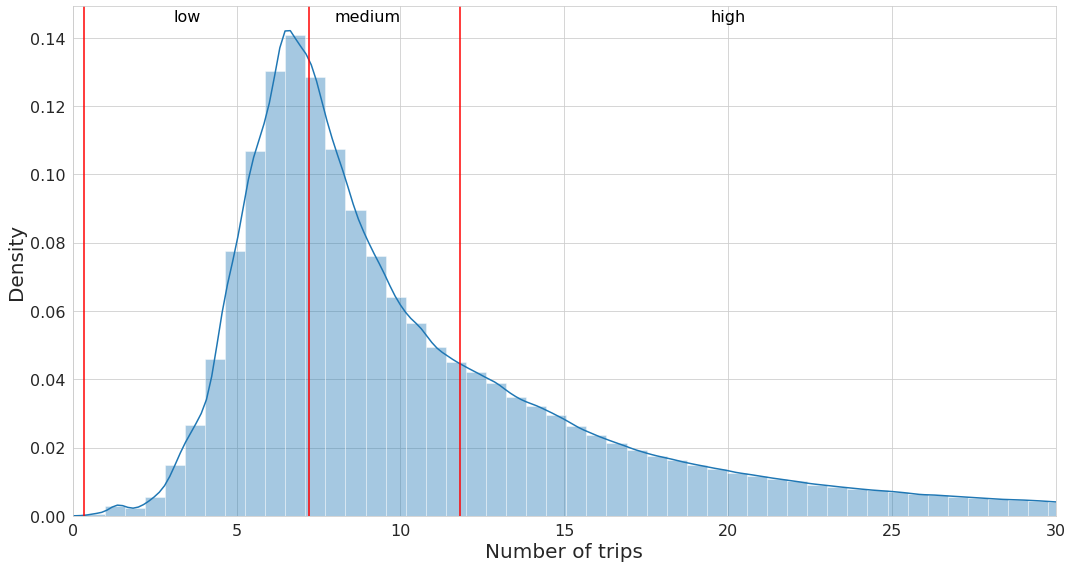

In [448]:
plt.figure(figsize=(15,8));                                  

sns.set_style("whitegrid");
ax = sns.distplot(min_tour_flows['viajes']);
ax.set_xlabel('Number of trips', fontsize=20);
ax.set_ylabel('Density', fontsize=20);

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

plt.xlim(0, 30)

plt.axvline(0.355, 0, 1, color='r')
plt.axvline(7.2079, 0, 1, color='r')
plt.axvline(11.813, 0, 1, color='r')

plt.text(3.5, 0.145, "low", horizontalalignment='center', fontsize='16', color='black')
plt.text(9, 0.145, "medium", horizontalalignment='center', fontsize='16', color='black')
plt.text(20, 0.145, "high", horizontalalignment='center', fontsize='16', color='black')

plt.tight_layout()
plt.savefig(os.path.join('figs', 'trips_distribution.png'))

In [411]:
tour_flows['timestamp'].max(), tour_flows['timestamp'].min() 

(Timestamp('2021-04-30 00:00:00'), Timestamp('2020-04-01 00:00:00'))

In [412]:
quantile_codes =dict(zip(['low', 'med', 'high'],np.arange(1,4)))

In [413]:
quantile_codes

{'low': 1, 'med': 2, 'high': 3}

Total trips

In [414]:
tour_flows['viajes'].sum()

277321888.6699999

## Read touristic flows of TWT

In [354]:
twt_tour_flows= pd.read_csv(os.path.join('data', 'mobility', 'twt_tour_flows.csv'), index_col=0, parse_dates=[0])
#Filter the selected dates
twt_tour_flows= twt_tour_flows.loc['2020-04-01':'2021-04-30']
twt_tour_flows.head()

,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,01059,...,50240_AM,50251_AM,50252,50272,50288,50297,50298,50903_AM,51001,52001
2020-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2020-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
2020-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2020-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2020-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [355]:
twt_tour_flows.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 395 entries, 2020-04-01 to 2021-04-30
Columns: 2148 entries, 01001_AM to 52001
dtypes: float64(2148)
memory usage: 6.5 MB


## Read regions tourist data

In [356]:
agg_mun_tourist_gdf= gpd.read_file(os.path.join('data','agg_mun_tourist.geojson'),driver='GeoJSON')
agg_mun_tourist_gdf.head()

,primary_key,area_km2,Viv-total,hotels-total,camps-total,POB20,HOMBRES,MUJERES,Viv-per-area,hotels-per-area,camps-per-area,geometry
0,01001_AM,359.212,17.0,4.0,1.0,7470,3945,3525,0.047326,0.011135,0.002784,"POLYGON ((-2.46644 42.78842, -2.46983 42.78803..."
1,01002,96.348,8.0,1.0,1.0,10264,5044,5220,0.083032,0.010379,0.010379,"MULTIPOLYGON (((-2.97525 42.93816, -2.97702 42..."
2,01010_AM,197.821,17.0,0.0,0.0,5971,3021,2950,0.085936,0.000000,0.000000,"POLYGON ((-3.00076 43.06800, -3.00853 43.06362..."
3,01031_AM,372.013,50.0,18.0,1.0,7428,3851,3577,0.134404,0.048385,0.002688,"MULTIPOLYGON (((-2.48257 42.49991, -2.48180 42..."
4,01036,37.559,5.0,1.0,0.0,18118,8868,9250,0.133124,0.026625,0.000000,"POLYGON ((-2.93850 43.13864, -2.93541 43.13658..."


In [357]:
agg_mun_tourist_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [358]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def calculate_gm_flow(r1, r2):
    p1 = agg_mun_tourist_gdf[agg_mun_tourist_gdf['primary_key']==r1]['POB20'].values[0]
    p2 = agg_mun_tourist_gdf[agg_mun_tourist_gdf['primary_key']==r2]['POB20'].values[0]
    
    lon1=  agg_mun_tourist_gdf[agg_mun_tourist_gdf['primary_key']==r1]['geometry'].values[0].centroid.x
    lat1= agg_mun_tourist_gdf[agg_mun_tourist_gdf['primary_key']==r1]['geometry'].values[0].centroid.y
    
    lon2=  agg_mun_tourist_gdf[agg_mun_tourist_gdf['primary_key']==r2]['geometry'].values[0].centroid.x
    lat2= agg_mun_tourist_gdf[agg_mun_tourist_gdf['primary_key']==r2]['geometry'].values[0].centroid.y
        
    d = haversine_np(lon1, lat1, lon2, lat2)
    return (p1*p2)/d

## Compose gravity model matrix

In [359]:
"""
node_names = pd.unique(tour_flows[['origen', 'destino']].values.ravel('K'))
gm_df = pd.DataFrame(index=node_names, columns=node_names)

unique_flows = tour_flows.drop_duplicates('origen destino'.split())

unique_flows= unique_flows[(~unique_flows['origen'].isin(blacklist)) & (~unique_flows['destino'].isin(blacklist))]

#unique_flows.head()

unique_flows_dict = unique_flows.to_dict('records')

for row in tqdm(unique_flows_dict, desc='Generating gravity-model flows...'):
    o_node = row['origen']
    d_node= row['destino']
    
    if gm_df.loc[o_node, d_node] is np.NaN:
        gm_flow = calculate_gm_flow(o_node, d_node)
        gm_df.loc[o_node, d_node]= gm_flow
        gm_df.loc[d_node, o_node]= gm_flow

#gm_df.head()

gm_df.to_csv(os.path.join('data', 'mobility','gm_flows.csv'))
"""

"\nnode_names = pd.unique(tour_flows[['origen', 'destino']].values.ravel('K'))\ngm_df = pd.DataFrame(index=node_names, columns=node_names)\n\nunique_flows = tour_flows.drop_duplicates('origen destino'.split())\n\nunique_flows= unique_flows[(~unique_flows['origen'].isin(blacklist)) & (~unique_flows['destino'].isin(blacklist))]\n\n#unique_flows.head()\n\nunique_flows_dict = unique_flows.to_dict('records')\n\nfor row in tqdm(unique_flows_dict, desc='Generating gravity-model flows...'):\n    o_node = row['origen']\n    d_node= row['destino']\n    \n    if gm_df.loc[o_node, d_node] is np.NaN:\n        gm_flow = calculate_gm_flow(o_node, d_node)\n        gm_df.loc[o_node, d_node]= gm_flow\n        gm_df.loc[d_node, o_node]= gm_flow\n\n#gm_df.head()\n\ngm_df.to_csv(os.path.join('data', 'mobility','gm_flows.csv'))\n"

## Prepare data structures

In [360]:
def get_node_codes(flow_df, node_info_df):
    node_names = pd.unique(flow_df[['origen', 'destino']].values.ravel('K'))
    
    code_to_node={}
    node_to_code={}
    clean_nodes =[]
    black_list= []
    i=0
    for n in tqdm_notebook(node_names, desc='Generating node codes...'):
            
        try:
            n_feat= node_info_df[node_info_df['primary_key']==n]['POB20 Viv-per-area hotels-per-area camps-per-area'.split()].values[0]
            code_to_node[i]= n
            node_to_code[n]=i
            clean_nodes.append(n)
            i+=1
        except:
            #The node does not have features so it cannot be included in the graph.
            black_list.append(n)
            
    return clean_nodes, code_to_node, node_to_code, black_list

In [361]:
i_date = tour_flows['timestamp'].min()
e_date = tour_flows['timestamp'].max()
dates= pd.date_range(i_date,e_date,freq='d')

In [362]:
clean_nodes, code_to_node, node_to_code, blacklist= get_node_codes(tour_flows, agg_mun_tourist_gdf)

Generating node codes...:   0%|          | 0/2238 [00:00<?, ?it/s]

## Compose series 

In [363]:
def compose_timeseries(df, column, dates, nodes):
    ts_all = pd.DataFrame(index=dates)
    for n in tqdm_notebook(nodes):
        ts= df.loc[:,n,:].droplevel(column)
        ts_all[n]= ts
        ts_all[n] = ts_all[n].fillna(0)
    return ts_all

def normalize_timeseries(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(df)
    df_normalized = pd.DataFrame(np_scaled, columns = df.columns)
    return df_normalized

### Out degree series

In [364]:
all_out_degress= tour_flows.groupby(['timestamp','origen']).size().to_frame()
all_out_degress.columns=['out_degree']
all_out_degress.head()

out_degree
timestamp  origen              
2020-04-01 01001_AM          35
           01002              1
           01010_AM           5
           01031_AM           9
           01036             10

In [365]:
out_degress_ts = compose_timeseries(all_out_degress, 'origen', dates, clean_nodes)
out_degress_norm_ts= normalize_timeseries(out_degress_ts)

  0%|          | 0/2201 [00:00<?, ?it/s]

In [366]:
out_degress_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 395 entries, 2020-04-01 to 2021-04-30
Freq: D
Columns: 2201 entries, 01001_AM to 38045_AM
dtypes: float64(1651), int64(550)
memory usage: 6.6 MB


In [367]:
out_degress_ts.head()

,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,01059,...,20903,40149_AM,07008,07061,33072_AM,07029,35029,35013,07001,38045_AM
2020-04-01,35,1.0,5.0,9.0,10.0,11.0,21.0,7.0,7.0,52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-02,31,1.0,4.0,12.0,25.0,9.0,21.0,13.0,7.0,56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-03,33,2.0,3.0,7.0,12.0,7.0,17.0,10.0,12.0,56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-04,17,0.0,0.0,1.0,5.0,1.0,6.0,2.0,2.0,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-05,29,0.0,0.0,1.0,3.0,0.0,6.0,2.0,3.0,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [368]:
out_degress_ts.tail()

,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,01059,...,20903,40149_AM,07008,07061,33072_AM,07029,35029,35013,07001,38045_AM
2021-04-26,38,7.0,2.0,15.0,19.0,13.0,20.0,8.0,19.0,81,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2021-04-27,38,10.0,14.0,9.0,15.0,8.0,34.0,15.0,13.0,95,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0
2021-04-28,44,2.0,0.0,11.0,23.0,8.0,22.0,14.0,6.0,82,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0
2021-04-29,48,18.0,9.0,11.0,25.0,10.0,33.0,17.0,22.0,119,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,5.0
2021-04-30,49,9.0,3.0,10.0,25.0,6.0,26.0,20.0,23.0,104,...,0.0,0.0,2.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0


In [369]:
out_degress_norm_ts.head()

,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,01059,...,20903,40149_AM,07008,07061,33072_AM,07029,35029,35013,07001,38045_AM
0,0.428571,0.052632,0.3125,0.183673,0.217391,0.407407,0.344262,0.333333,0.194444,0.192140,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.371429,0.052632,0.2500,0.244898,0.543478,0.333333,0.344262,0.619048,0.194444,0.209607,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.400000,0.105263,0.1875,0.142857,0.260870,0.259259,0.278689,0.476190,0.333333,0.209607,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.171429,0.000000,0.0000,0.020408,0.108696,0.037037,0.098361,0.095238,0.055556,0.034934,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.342857,0.000000,0.0000,0.020408,0.065217,0.000000,0.098361,0.095238,0.083333,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [370]:
out_degress_norm_ts.tail()

,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,01059,...,20903,40149_AM,07008,07061,33072_AM,07029,35029,35013,07001,38045_AM
390,0.471429,0.368421,0.1250,0.306122,0.413043,0.481481,0.327869,0.380952,0.527778,0.318777,...,0.0,0.0,0.0,0.000,0.0,0.333333,0.125,0.000000,0.000000,0.000000
391,0.471429,0.526316,0.8750,0.183673,0.326087,0.296296,0.557377,0.714286,0.361111,0.379913,...,0.0,0.0,0.0,0.000,0.0,0.000000,0.375,0.166667,0.000000,0.090909
392,0.557143,0.105263,0.0000,0.224490,0.500000,0.296296,0.360656,0.666667,0.166667,0.323144,...,0.0,0.0,0.0,0.125,0.0,0.000000,0.000,0.166667,0.000000,0.181818
393,0.614286,0.947368,0.5625,0.224490,0.543478,0.370370,0.540984,0.809524,0.611111,0.484716,...,0.0,0.0,0.0,0.000,0.0,0.000000,0.125,0.333333,0.333333,0.454545
394,0.628571,0.473684,0.1875,0.204082,0.543478,0.222222,0.426230,0.952381,0.638889,0.419214,...,0.0,0.0,0.5,0.125,0.0,0.333333,0.125,0.333333,0.000000,0.181818


In [371]:
out_degress_norm_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Columns: 2201 entries, 01001_AM to 38045_AM
dtypes: float64(2201)
memory usage: 6.6 MB


The loop below just checks the integrity of the mapping code to node in the feature matrix and the edges

In [372]:
indexes= out_degress_norm_ts.T.index
for i in tqdm_notebook(range(len(indexes))):
    node = indexes[i]
    code = node_to_code[node]
    if i!= code:
        print(f"error for node {node}, {i}!={code}")

  0%|          | 0/2201 [00:00<?, ?it/s]

### In degree

In [373]:
all_in_degress= tour_flows.groupby(['timestamp','destino']).size().to_frame()
all_in_degress.columns=['in_degree']
all_in_degress.head()

in_degree
timestamp  destino            
2020-04-01 01001_AM         23
           01010_AM          2
           01031_AM         14
           01036            14
           01043_AM          5

In [374]:
in_degress_ts = compose_timeseries(all_in_degress, 'destino', dates, clean_nodes)
in_degress_norm_ts= normalize_timeseries(in_degress_ts)

  0%|          | 0/2201 [00:00<?, ?it/s]

In [375]:
in_degress_norm_ts.head()

,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,01059,...,20903,40149_AM,07008,07061,33072_AM,07029,35029,35013,07001,38045_AM
0,0.338710,0.000000,0.1250,0.291667,0.279070,0.161290,0.294118,0.083333,0.111111,0.223958,...,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000
1,0.306452,0.333333,0.1875,0.333333,0.418605,0.322581,0.431373,0.250000,0.148148,0.213542,...,0.0,0.0,0.000000,0.05,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0.274194,0.166667,0.1250,0.104167,0.139535,0.161290,0.137255,0.083333,0.111111,0.187500,...,0.0,0.0,0.000000,0.00,0.0,0.0,0.071429,0.0,0.0,0.052632
3,0.129032,0.000000,0.0000,0.062500,0.069767,0.000000,0.098039,0.125000,0.000000,0.031250,...,0.0,0.0,0.111111,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0.225806,0.000000,0.0625,0.062500,0.209302,0.032258,0.078431,0.208333,0.148148,0.052083,...,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.052632


In [376]:
indexes= in_degress_norm_ts.T.index
for i in tqdm_notebook(range(len(indexes))):
    node = indexes[i]
    code = node_to_code[node]
    if i!= code:
        print(f"error for node {node}, {i}!={code}")

  0%|          | 0/2201 [00:00<?, ?it/s]

### Incoming number of trips

In [377]:
all_incoming_flows=tour_flows.groupby(['timestamp','destino']).sum()
all_incoming_flows.head()

viajes
timestamp  destino          
2020-04-01 01001_AM  229.867
           01010_AM   29.953
           01031_AM  135.432
           01036     143.046
           01043_AM   45.821

In [378]:
in_flows_ts = compose_timeseries(all_incoming_flows, 'destino', dates, clean_nodes)
in_flows_norm_ts= normalize_timeseries(in_flows_ts)

  0%|          | 0/2201 [00:00<?, ?it/s]

In [379]:
in_flows_norm_ts.head()

,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,01059,...,20903,40149_AM,07008,07061,33072_AM,07029,35029,35013,07001,38045_AM
0,0.238433,0.000000,0.119832,0.175159,0.135981,0.109020,0.251811,0.196732,0.161444,0.158387,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
1,0.246447,0.179118,0.119240,0.227515,0.236454,0.342582,0.303414,0.146187,0.068468,0.192843,...,0.0,0.0,0.000000,0.035336,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0.197141,0.067432,0.064887,0.110178,0.098638,0.088756,0.144003,0.050936,0.125591,0.163726,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.022218,0.0,0.0,0.008600
3,0.096899,0.000000,0.000000,0.023205,0.087125,0.000000,0.068844,0.174399,0.000000,0.028590,...,0.0,0.0,0.101851,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0.122837,0.000000,0.109666,0.039770,0.075005,0.009810,0.064825,0.149358,0.098893,0.031617,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.016035


In [380]:
indexes= in_flows_norm_ts.T.index
for i in tqdm_notebook(range(len(indexes))):
    node = indexes[i]
    code = node_to_code[node]
    if i!= code:
        print(f"error for node {node}, {i}!={code}")

  0%|          | 0/2201 [00:00<?, ?it/s]

### Outgoing number of trips

In [381]:
all_outgoing_flows=tour_flows.groupby(['timestamp','origen']).sum()
all_outgoing_flows.head()

viajes
timestamp  origen           
2020-04-01 01001_AM  526.390
           01002       8.620
           01010_AM   31.385
           01031_AM   72.182
           01036     173.942

In [382]:
out_flows_ts = compose_timeseries(all_outgoing_flows, 'origen', dates, clean_nodes)
out_flows_norm_ts= normalize_timeseries(out_flows_ts)

  0%|          | 0/2201 [00:00<?, ?it/s]

In [383]:
out_flows_norm_ts.head()

,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,01059,...,20903,40149_AM,07008,07061,33072_AM,07029,35029,35013,07001,38045_AM
0,0.524714,0.028044,0.148520,0.124966,0.231818,0.395964,0.292221,0.289439,0.169485,0.147099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.312879,0.025614,0.236629,0.281500,0.406935,0.302166,0.299539,0.383839,0.276228,0.147456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.287774,0.042834,0.134451,0.158497,0.142133,0.188777,0.238233,0.437542,0.405425,0.148642,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.161100,0.000000,0.000000,0.012462,0.065800,0.018847,0.093952,0.054060,0.025102,0.014962,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.303169,0.000000,0.000000,0.028768,0.043512,0.000000,0.054904,0.125054,0.080000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [384]:
len(out_flows_norm_ts.T.index.tolist())

2201

In [385]:
agg_mun_tourist_gdf[agg_mun_tourist_gdf['primary_key'].isin(out_flows_norm_ts.T.index.tolist())]

,primary_key,area_km2,Viv-total,hotels-total,camps-total,POB20,HOMBRES,MUJERES,Viv-per-area,hotels-per-area,camps-per-area,geometry
0,01001_AM,359.212,17.00,4.0,1.0,7470,3945,3525,0.047326,0.011135,0.002784,"POLYGON ((-2.46644 42.78842, -2.46983 42.78803..."
1,01002,96.348,8.00,1.0,1.0,10264,5044,5220,0.083032,0.010379,0.010379,"MULTIPOLYGON (((-2.97525 42.93816, -2.97702 42..."
2,01010_AM,197.821,17.00,0.0,0.0,5971,3021,2950,0.085936,0.000000,0.000000,"POLYGON ((-3.00076 43.06800, -3.00853 43.06362..."
3,01031_AM,372.013,50.00,18.0,1.0,7428,3851,3577,0.134404,0.048385,0.002688,"MULTIPOLYGON (((-2.48257 42.49991, -2.48180 42..."
4,01036,37.559,5.00,1.0,0.0,18118,8868,9250,0.133124,0.026625,0.000000,"POLYGON ((-2.93850 43.13864, -2.93541 43.13658..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2203,35004,24.276,401.00,0.0,0.0,64645,32443,32202,16.518372,0.000000,0.000000,"MULTIPOLYGON (((-13.54974 28.95257, -13.54947 ..."
2204,35016,103.316,2.25,0.0,0.0,381223,183905,197318,0.021778,0.000000,0.000000,"MULTIPOLYGON (((-15.46377 28.12838, -15.46372 ..."
2205,35026,100.331,357.00,0.0,0.0,102791,50425,52366,3.558222,0.000000,0.000000,"MULTIPOLYGON (((-15.36495 27.99313, -15.36494 ..."
2206,38023,102.452,568.00,0.0,0.0,158911,76703,82208,5.544060,0.000000,0.000000,"MULTIPOLYGON (((-16.39861 28.53414, -16.39852 ..."


In [386]:
indexes= out_flows_norm_ts.T.index
for i in tqdm_notebook(range(len(indexes))):
    node = indexes[i]
    code = node_to_code[node]
    if i!= code:
        print(f"error for node {node}, {i}!={code}")

  0%|          | 0/2201 [00:00<?, ?it/s]

### TWT visitors timeseries

We need to add some more columns to the TWT timeseries (some MAs do not have TWT data)

In [387]:
out_flows_ts.shape

(395, 2201)

In [388]:
twt_tour_flows.reset_index(drop=True).shape

(395, 2148)

In [389]:
twt_ts = pd.DataFrame(0, columns=out_flows_ts.columns, index=out_flows_ts.index)

In [390]:
for c in tqdm_notebook(out_flows_norm_ts.columns):
    if c in twt_tour_flows.columns:
        twt_ts[c]= twt_tour_flows[c]

  0%|          | 0/2201 [00:00<?, ?it/s]

In [391]:
twt_norm_ts= normalize_timeseries(twt_ts)

In [392]:
twt_norm_ts.head()

,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,01059,...,20903,40149_AM,07008,07061,33072_AM,07029,35029,35013,07001,38045_AM
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.1,...,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0


No NaN values

In [393]:
twt_norm_ts.isna().sum().sum()

0

In [394]:
twt_norm_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Columns: 2201 entries, 01001_AM to 38045_AM
dtypes: float64(2201)
memory usage: 6.6 MB


## Compose dynamic graph structure

In [395]:
edge_types = 'tour_infras_totals'

In [396]:
gm_df = pd.read_csv(os.path.join('data', 'mobility','infrastructure_edge_weights_w_totals.csv'), index_col=0)
gm_df = gm_df.fillna(0.0)
gm_df.head()

,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,01059,...,20903,40149_AM,07008,07061,33072_AM,07029,35029,35013,07001,38045_AM
01001_AM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01010_AM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01031_AM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.752822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [397]:
gm_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2238 entries, 01001_AM to 38045_AM
Columns: 2238 entries, 01001_AM to 38045_AM
dtypes: float64(2238)
memory usage: 38.2+ MB


In [398]:
def prepare_static_graph(node_codes,
                        node_info_df):
    
    X_static= []
    #Here we add the nodes' features related to their touristic infraestructure
    i=0
    codes= np.sort(list(node_codes.keys()))
    for i in codes:
        n= node_codes[i]
        n_feat= node_info_df[node_info_df['primary_key']==n]['POB20 Viv-per-area hotels-per-area camps-per-area'.split()].values[0]
        X_static.append(n_feat.tolist())
    return X_static

def prepare_snapshot(snap_flow_df,
                     in_degree_df, 
                     out_degree_df, 
                     in_trips_df, 
                     out_trips_df,
                     twt_df,
                     gm_df,
                     node_codes, 
                     black_list, 
                     q_codes,
                     date_index,
                     nlags):
    
    snap = {}
    snap['index']=date_index
    snap['edges']=[]
    snap['weights']=[]
    snap['X']=[]
    snap['y']=[]

 
    indegree_values = in_degree_df.T.values[:,date_index:date_index+nlags]
    outdegree_values = out_degree_df.T.values[:,date_index:date_index+nlags]
    intrip_values = in_trips_df.T.values[:,date_index:date_index+nlags]
    outrip_values = out_trips_df.T.values[:,date_index:date_index+nlags]
    twt_values = twt_df.T.values[:,date_index:date_index+nlags]
    
    ts= np.hstack((indegree_values, outdegree_values, intrip_values,outrip_values,twt_values))
    ts= ts.reshape(-1,5,nlags) #5 different features
    snap['X']= ts.tolist()
  
    #Map nodes to code
    inv_codes = {v: k for k, v in node_codes.items()}
    # We add the edges and their weights
    for index, f in snap_flow_df.iterrows():
        o_node = f['origen']
        d_node= f['destino']

        if (o_node not in black_list) and (d_node not in black_list):
            snap['edges'].append([int(inv_codes[o_node]), int(inv_codes[d_node])])
            snap['weights'].append(float(gm_df.loc[o_node, d_node])) 
            snap['y'].append(int(q_codes[f['viajes_quartile']]))

    return snap

def to_json(dataset, target_trip, edge_types):

    with open(os.path.join('data', 'graph_datasets',f'dynamic_G_tourist_flow_{target_trip}_{edge_types}_twt.json'), 'w') as outfile:
        json.dump(dataset, outfile)

In [399]:
nlags = 7

dates = np.sort(tour_flows['timestamp'].unique())

def prepare_dynamic_graph(tour_flow_df,
                          in_degress_ts, 
                          out_degress_ts,
                          in_flows_ts,
                          out_flows_ts,
                          twt_df,
                          gm_df,
                          code_to_node,
                          blacklist, 
                          target_slice,
                          nlags):

    dataset = {}
    
    target_flow = tour_flow_df[tour_flow_df['viajes_quartile']==target_slice]

    for d in tqdm_notebook(range(len(dates)-nlags), desc=f'Generating snapshots for trips of type {target_slice}...'): #for all the snapshots
    #for d in tqdm_notebook(range(10), desc=f'Generating snapshots for trips of type {target_slice}...'):

        date_flow_df = target_flow[target_flow['timestamp']==dates[d]]

        snap= prepare_snapshot(date_flow_df,
                               in_degress_ts, 
                               out_degress_ts,
                               in_flows_ts,
                               out_flows_ts,
                               twt_df,
                               gm_df,
                               code_to_node, 
                               blacklist, 
                               quantile_codes,
                               d,
                               nlags)

        dataset[str(d)]= snap

    #Convert node codes from np.int64 to int
    dataset['node_ids']= dict([(int(c),n) for (c,n)  in code_to_node.items()])
    dataset['time_periods']= len(dates)-nlags
    return dataset

for trip_type in tqdm_notebook(['low', 'med', 'high']):
    dynamic_G =prepare_dynamic_graph(tour_flows,
                                         in_degress_norm_ts, 
                                         out_degress_norm_ts,
                                         in_flows_norm_ts,
                                         out_flows_norm_ts,
                                         twt_norm_ts,
                                         gm_df,
                                         code_to_node,
                                         blacklist, 
                                         trip_type,
                                         nlags)
    
    to_json(dynamic_G, trip_type, edge_types)


static_G = prepare_static_graph(code_to_node, agg_mun_tourist_gdf)

  0%|          | 0/3 [00:00<?, ?it/s]

Generating snapshots for trips of type low...:   0%|          | 0/388 [00:00<?, ?it/s]

Generating snapshots for trips of type med...:   0%|          | 0/388 [00:00<?, ?it/s]

Generating snapshots for trips of type high...:   0%|          | 0/388 [00:00<?, ?it/s]

## Write dynamic and static graphs

In [400]:
import pickle

In [401]:
with open(os.path.join('data', 'graph_datasets','static_G_tourist_infrastructure'), 'wb') as fp:
    pickle.dump(static_G, fp)

In [402]:
with open(os.path.join('data', 'graph_datasets','node_to_codes_all_data_dynamic.json'), 'w') as outfile:
    json.dump(code_to_node, outfile)

## Test dataset loader

In [403]:
from importlib import reload
import tourist_mobility3
reload(tourist_mobility3)
from tourist_mobility3 import TouristMobDynamicDatasetLoader

loader= TouristMobDynamicDatasetLoader(target_slice='med', edges_type=edge_types, include_twt=True)

In [404]:
dataset=loader.get_dataset()

In [405]:
dataset

In [406]:
 print("That's all folks!")

That's all folks!
